
https://www.youtube.com/watch?v=SbE8ns0oOTs&t=474s


https://scholar.harvard.edu/stock/publications/vector-autoregressions

Get unemployment rate

In [9]:
import pandas as pd
import nasdaqdatalink
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from google.colab import userdata



In [10]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),maxlag=1,autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

Get unemployment rate from nasdaq-data-link

In [15]:
unemp = pd.read_csv("/content/UNRATE.csv")
fedfunds = pd.read_csv("/content/FEDFUNDS.csv")
infl = pd.read_csv("/content/CPIAUCNS.csv")

,observation_date,CPIAUCNS
0,1913-01-01,9.8
1,1913-02-01,9.8
2,1913-03-01,9.8
3,1913-04-01,9.8
4,1913-05-01,9.7


In [19]:
unemp = unemp[(unemp['observation_date'] >="1980-01-01") & (unemp['observation_date']<="2010-12-13")]


In [21]:
ir=fedfunds[(fedfunds['observation_date'] >="1980-01-01") & (fedfunds['observation_date']<="2010-12-13")]

In [22]:
infl=infl[(infl['observation_date'] >="1980-01-01") & (infl['observation_date']<="2010-12-13")]

In [24]:
unemp.set_index('observation_date',inplace=True)
unemp.index = pd.to_datetime(unemp.index)
ir  = ir.set_index('observation_date')
ir.index = pd.to_datetime(ir.index)
infl.set_index('observation_date',inplace=True)
infl.index = pd.to_datetime(infl.index)

In [25]:
df = unemp.join(ir)

In [26]:
df = df.join(infl)


In [28]:
df.rename(columns={'UNRATE':'unemp_rate','FEDFUNDS':'interest_rate','CPIAUCNS':'inflation_rate'},inplace=True)

In [29]:
df.head()

,unemp_rate,interest_rate,inflation_rate
observation_date,,,
1980-01-01,6.3,13.82,77.8
1980-02-01,6.3,14.13,78.9
1980-03-01,6.3,17.19,80.1
1980-04-01,6.9,17.61,81.0
1980-05-01,7.5,10.98,81.8


Using Granger’s Causality Test, it’s possible to test this relationship before even building the model.

So what does Granger’s Causality really test?

Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero.

In simpler terms, the past values of time series (X) do not cause the other series (Y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis.

The below code implements the Granger’s Causality test for all possible combinations of the time series in a given dataframe and stores the p-values of each combination in the output matrix.

In [30]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table
    are the P-Values. P-Values lesser than the significance level (0.05), implies
    the Null Hypothesis that the coefficients of the corresponding past values is
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print resul

,unemp_rate_x,interest_rate_x,inflation_rate_x
unemp_rate_y,1.0000,0.0007,0.0801
interest_rate_y,0.0000,1.0000,0.0015
inflation_rate_y,0.0448,0.0036,1.0000


If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

---



Checking cointegration

Cointegration, in econometrics and time series analysis, refers to the existence of a long-term relationship between two or more non-stationary time series, even if individually they are non-stationary (have trends). In other words, the series may have individual non-stationary movements, but their linear combination can be stationary.

In [70]:
import statsmodels.api as sm

Xc = sm.add_constant(df['interest_rate'])
model = sm.OLS(df['inflation_rate'], Xc) #Ordinary Least Squares
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         inflation_rate   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     736.5
Date:                Sun, 11 May 2025   Prob (F-statistic):           6.06e-90
Time:                        00:44:13   Log-Likelihood:                -1688.6
No. Observations:                 371   AIC:                             3381.
Df Residuals:                     369   BIC:                             3389.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           200.7686      2.164     92.795

In [71]:
from statsmodels.tsa.stattools import adfuller

adfuller(results.resid,maxlag=1)

(np.float64(-3.4797473120884965),
 np.float64(0.008522717427708625),
 1,
 369,
 {'1%': np.float64(-3.448196541708585),
  '5%': np.float64(-2.869404683789669),
  '10%': np.float64(-2.5709597356805545)},
 np.float64(2181.1625584165186))

Interest_rate and inflation rate are cointegrated

In [72]:
Xc = sm.add_constant(df['inflation_rate']) #para obtener la ordenada en el origen
model = sm.OLS(df['interest_rate'], Xc) #Ordinary Least Squares
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          interest_rate   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     736.5
Date:                Sun, 11 May 2025   Prob (F-statistic):           6.06e-90
Time:                        00:44:45   Log-Likelihood:                -822.57
No. Observations:                 371   AIC:                             1649.
Df Residuals:                     369   BIC:                             1657.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             17.8143      0.457     38.

In [73]:
from statsmodels.tsa.stattools import adfuller

adfuller(results.resid,maxlag=1)

(np.float64(-4.865365217810874),
 np.float64(4.071210463556512e-05),
 1,
 369,
 {'1%': np.float64(-3.448196541708585),
  '5%': np.float64(-2.869404683789669),
  '10%': np.float64(-2.5709597356805545)},
 np.float64(593.8607267922293))

In [74]:
Xc = sm.add_constant(df['unemp_rate']) #para obtener la ordenada en el origen
model = sm.OLS(df['inflation_rate'], Xc) #Ordinary Least Squares
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         inflation_rate   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     41.98
Date:                Sun, 11 May 2025   Prob (F-statistic):           2.95e-10
Time:                        00:45:10   Log-Likelihood:                -1872.2
No. Observations:                 371   AIC:                             3748.
Df Residuals:                     369   BIC:                             3756.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        200.7426      7.803     25.726      0.0

In [75]:
adfuller(results.resid,maxlag=1)

(np.float64(0.6605000582073755),
 np.float64(0.9890157002773158),
 1,
 369,
 {'1%': np.float64(-3.448196541708585),
  '5%': np.float64(-2.869404683789669),
  '10%': np.float64(-2.5709597356805545)},
 np.float64(1313.2291231174586))

VAR model (Vector Autoregression model)

https://www.econometrics-with-r.org/16.1-vector-autoregressions.html



An AR(p) model is:

$y_t=\phi_0+\phi_1y_{t-1}+\phi_2y_{t-2}+...+\phi_py_{t-p}+\varepsilon_t$

where $\epsilon_t$ are the error terms (white noise), usually called also innovations or shock terms.

Let's consider k processes:

$y_{1,t}=\phi_{1,0}+\phi_{1,1}y_{1,t-1}+\phi_{1,2}y_{1,t-2}+...+\phi_{1,p}y_{1,t-p}+\epsilon_t$

$y_{2,t}=\phi_{2,0}+\phi_{2,1}y_{2,t-1}+\phi_{2,2}y_{2,t-2}+...+\phi_{2,p}y_{2,t-p}+\epsilon_t$
.
.
.

$y_{k,t}=\phi_{k,0}+\phi_{k,1}y_{k,t-1}+\phi_{k,2}y_{k,t-2}+...+\phi_{k,p}y_{k,t-p}+\epsilon_t$

In the VAR model, we have multiple time series variables that influence each other and here, it is modelled as a system of equations with one equation per time series variable.


$$\begin{bmatrix}
y_1 \\
y_2 \\
... \\
y_k \\
\end{bmatrix}=\begin{bmatrix}
\phi_{1,0} \\
\phi_{2,0} \\
... \\
\phi_{k,0} \\
\end{bmatrix}+\begin{bmatrix}
\phi_{1,1} & \\
\phi_{2,1} & \\
...& \\
\phi_{k,1} & \
\end{bmatrix}\begin{bmatrix}
y_{1,t-1} \\
y_{2,t-1} \\
...\\
y_{k,t-1} \\
\end{bmatrix}+\begin{bmatrix}
\phi_{1,2} \\
\phi_{2,2} \\
...& \\
\phi_{k,2}
\end{bmatrix}\begin{bmatrix}
y_{1,t-2} \\
y_{2,t-2} \\
...\\
y_{k,t-2} \\
\end{bmatrix}+...+\begin{bmatrix}
\phi_{1,k}\\
\phi_{2,k}\\
...\\
\phi_{k,k}
\end{bmatrix}\begin{bmatrix}
y_{1,t-p} \\
y_{2,t-p} \\
...\\
y_{k,t-p} \\
\end{bmatrix}+\begin{bmatrix}
\varepsilon_1 \\
\varepsilon_2 \\
... \\
\varepsilon_k \\
\end{bmatrix}
$$

The assumptions of the model are:

* The processes $y_i$ are stationary

* The coefficients are estimated with OLS

* The $\varepsilon_i$ are white noise disturbances (i.i.d.$\sim\mathcal{N}(0,1)$).


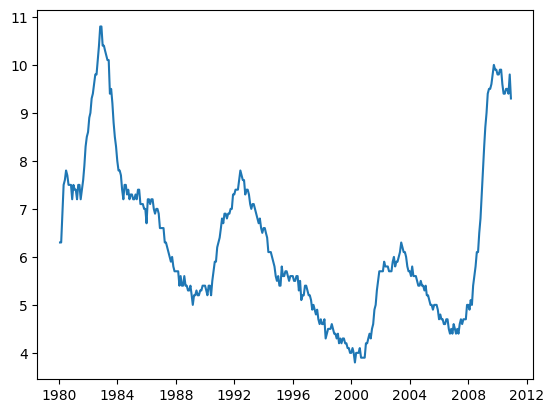

In [76]:
plt.plot(df['unemp_rate'])

In [77]:
adf_test(df['unemp_rate'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -0.584355
p-value                   0.874478
# lags used               1.000000
# observations          369.000000
critical value (1%)      -3.448197
critical value (5%)      -2.869405
critical value (10%)     -2.570960
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [78]:
adf_test(df['interest_rate'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.423607
p-value                   0.010180
# lags used               1.000000
# observations          369.000000
critical value (1%)      -3.448197
critical value (5%)      -2.869405
critical value (10%)     -2.570960
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


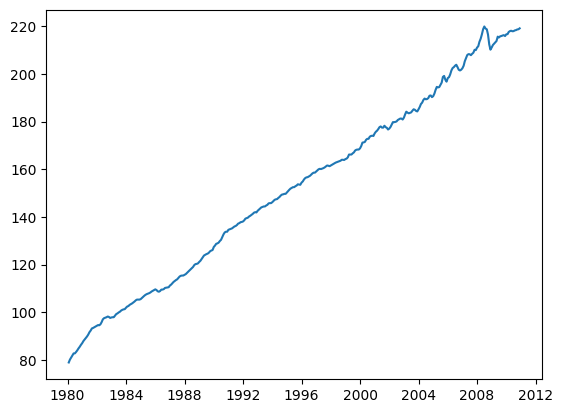

In [79]:
plt.plot(df['inflation_rate'])

In [80]:
adf_test(df['inflation_rate'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -0.613244
p-value                   0.867961
# lags used               1.000000
# observations          369.000000
critical value (1%)      -3.448197
critical value (5%)      -2.869405
critical value (10%)     -2.570960
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [81]:
df["inflation_rate_pct"] = df["inflation_rate"].pct_change()
df['interest_rate_pct'] = df['interest_rate'].pct_change()
df['unemp_rate_pct']=df['unemp_rate'].pct_change()

In [82]:
adf_test(df['interest_rate_pct'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.184243e+01
p-value                 7.534451e-22
# lags used             1.000000e+00
# observations          3.680000e+02
critical value (1%)    -3.448245e+00
critical value (5%)    -2.869426e+00
critical value (10%)   -2.570971e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [83]:
adf_test(df['inflation_rate_pct'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.075744e+01
p-value                 2.571562e-19
# lags used             1.000000e+00
# observations          3.680000e+02
critical value (1%)    -3.448245e+00
critical value (5%)    -2.869426e+00
critical value (10%)   -2.570971e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [84]:
adf_test(df['unemp_rate_pct'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.070381e+01
p-value                 3.468799e-19
# lags used             1.000000e+00
# observations          3.680000e+02
critical value (1%)    -3.448245e+00
critical value (5%)    -2.869426e+00
critical value (10%)   -2.570971e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [85]:
df.dropna(inplace=True)

In [86]:
df.head()

,unemp_rate,interest_rate,inflation_rate,inflation_rate_pct,interest_rate_pct,unemp_rate_pct
1980-03-01,6.3,17.19,80.1,0.015209,0.216561,0.000000
1980-04-01,6.9,17.61,81.0,0.011236,0.024433,0.095238
1980-05-01,7.5,10.98,81.8,0.009877,-0.376491,0.086957
1980-06-01,7.6,9.47,82.7,0.011002,-0.137523,0.013333
1980-07-01,7.8,9.03,82.7,0.000000,-0.046463,0.026316


In [106]:
data = df[['unemp_rate_pct','inflation_rate_pct','interest_rate_pct']]
test_obs = 10
train = data[:-test_obs]
test = data[-test_obs:]

In [107]:
aic = []
bic = []
order = []
for im in range(1,10):
    model = VAR(train)
    results = model.fit(im)
    print('Order =', im)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    aic.append(results.aic)
    bic.append(results.bic)
    order.append(im)

Order = 1
AIC:  -24.142273346645034
BIC:  -24.01246869856186
Order = 2
AIC:  -24.248020500436983
BIC:  -24.02039147050845
Order = 3
AIC:  -24.379901153483594
BIC:  -24.05404100375421
Order = 4
AIC:  -24.37926826530009
BIC:  -23.954767426807873
Order = 5
AIC:  -24.3821982413257
BIC:  -23.858644286692403
Order = 6
AIC:  -24.394490244175323
BIC:  -23.77146785985717
Order = 7
AIC:  -24.379760536637203
BIC:  -23.656851494830978
Order = 8
AIC:  -24.37493897387557
BIC:  -23.551722104074837
Order = 9
AIC:  -24.382198824576175
BIC:  -23.458249984772376


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

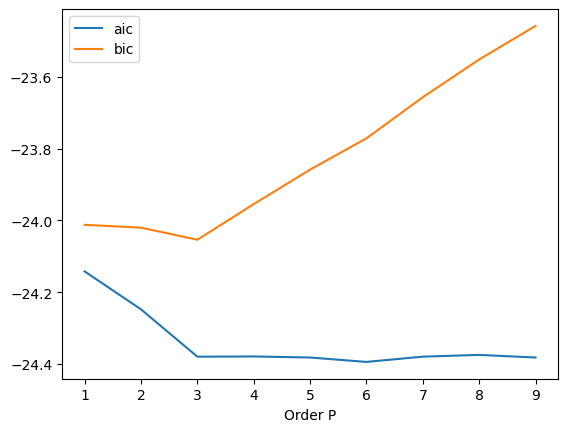

In [108]:
plt.plot(order,aic,label='aic')
plt.plot(order,bic,label='bic')
plt.xlabel('Order P')
plt.legend()

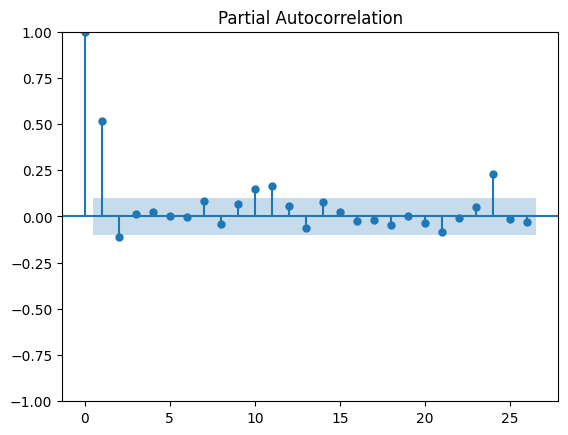

In [109]:
plot_pacf(data['inflation_rate_pct'])
plt.show()

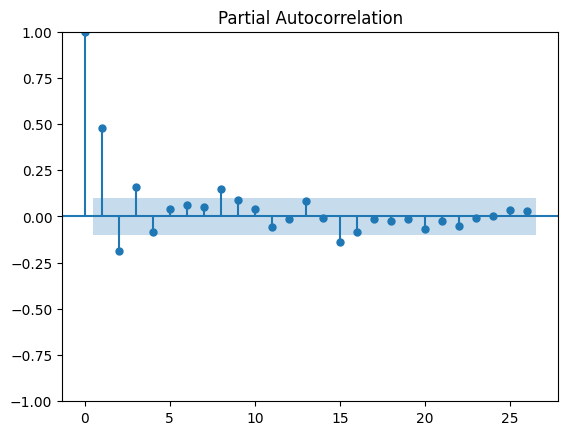

In [110]:
plot_pacf(data['interest_rate_pct'])
plt.show()

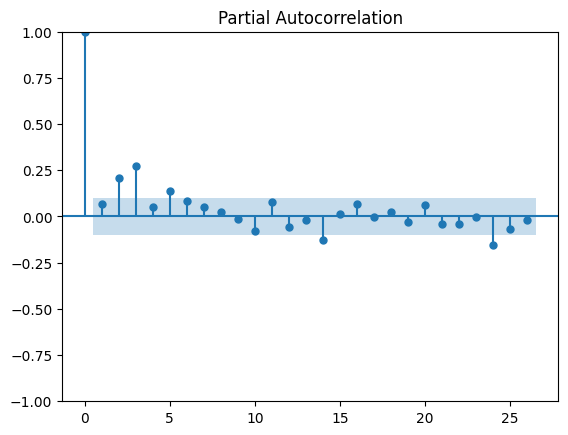

In [111]:
plot_pacf(data['unemp_rate_pct'])
plt.show()

In [112]:
model = VAR(data)
result = model.fit(3)
result.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 11, May, 2025
Time:                     00:49:33
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -24.0699
Nobs:                     367.000    HQIC:                  -24.2623
Log likelihood:           2943.15    FPE:                2.55838e-11
AIC:                     -24.3891    Det(Omega_mle):     2.36015e-11
--------------------------------------------------------------------
Results for equation unemp_rate_pct
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                        -0.002410         0.002010           -1.199           0.231
L1.unemp_rate_pct            -0.107538         0.051045           -2.107           0.035
L1.inflation_rate_p

In [113]:
result.resid

,unemp_rate_pct,inflation_rate_pct,interest_rate_pct
1980-06-01,-0.009070,0.007009,0.095152
1980-07-01,-0.019846,-0.005687,-0.044028
1980-08-01,-0.053073,0.006732,0.146161
1980-09-01,-0.037022,0.002283,0.098328
1980-10-01,-0.002900,0.004138,0.109013
...,...,...,...
2010-08-01,0.021107,-0.000870,0.022829
2010-09-01,0.006902,-0.002056,-0.015586
2010-10-01,-0.009369,-0.000192,0.025640
2010-11-01,0.043141,-0.001521,-0.002064


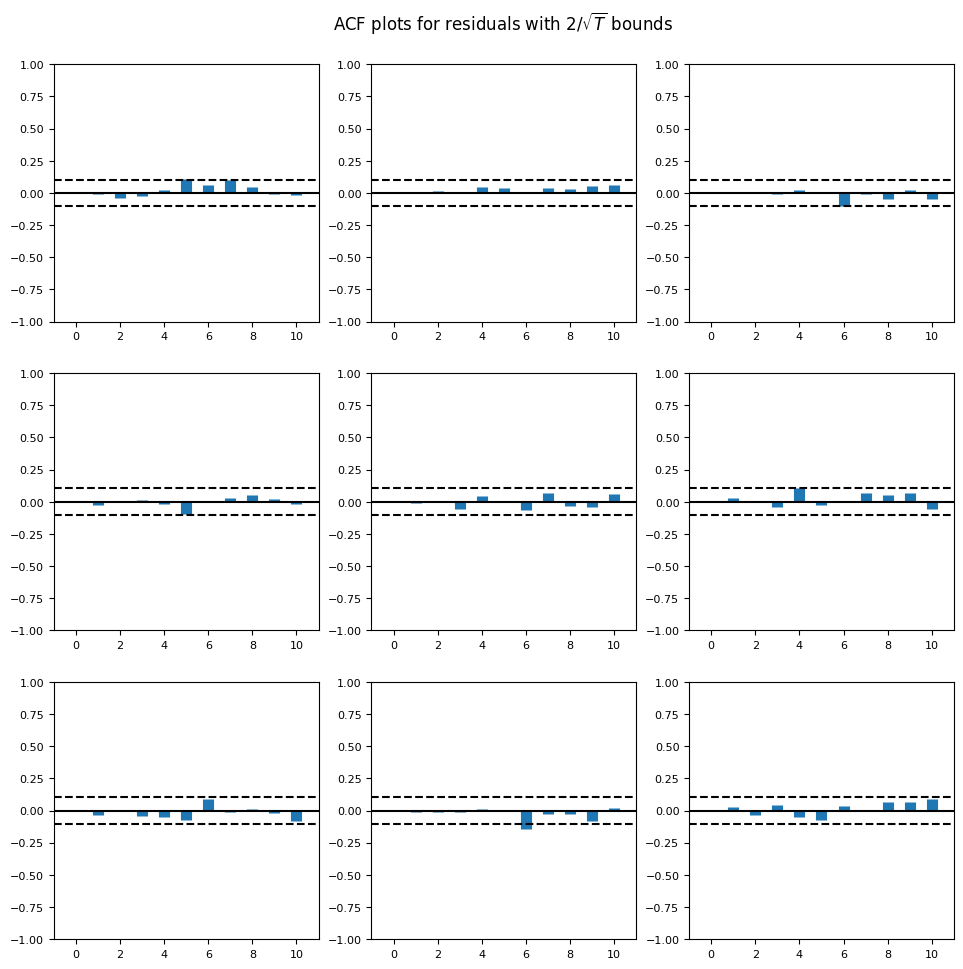

In [114]:
result.plot_acorr()
plt.show()

<Axes: >

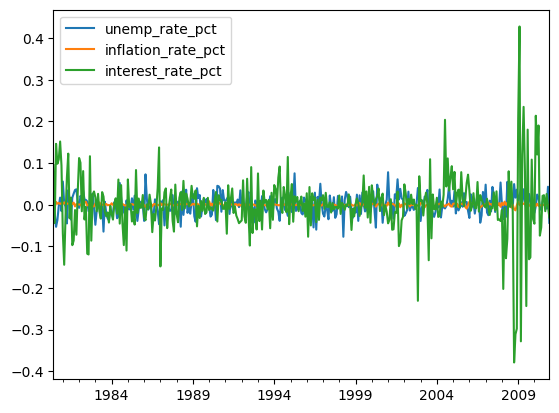

In [115]:
result.resid.plot()

In [116]:
test

,unemp_rate_pct,inflation_rate_pct,interest_rate_pct
2010-03-01,0.010204,0.004106,0.230769
2010-04-01,0.000000,0.001737,0.250000
2010-05-01,-0.030303,0.000775,0.000000
2010-06-01,-0.020833,-0.000976,-0.100000
2010-07-01,0.000000,0.000211,0.000000
2010-08-01,0.010638,0.001381,0.055556
2010-09-01,0.000000,0.000582,0.000000
2010-10-01,-0.010526,0.001245,0.000000
2010-11-01,0.042553,0.000421,0.000000
2010-12-01,-0.051020,0.001718,-0.052632


In [118]:
lagged_Values = train.values[-10:]
pred = result.forecast(y=lagged_Values, steps=12)
df_forecast=pd.DataFrame(data=pred,columns=['unemp', 'infl','rate'])

In [119]:
df_forecast

,unemp,infl,rate
0,-0.014129,0.001876,0.110112
1,-0.007242,0.002807,0.000546
2,-0.010526,0.002360,-0.003831
3,-0.007871,0.002414,0.015410
4,-0.003379,0.002761,0.013157
5,-0.004018,0.002903,0.006013
6,-0.003089,0.002840,0.003535
7,-0.001891,0.002785,0.002212
8,-0.001659,0.002781,0.000587
9,-0.001145,0.002769,-0.000717


In [120]:
train.tail()

,unemp_rate_pct,inflation_rate_pct,interest_rate_pct
2009-10-01,0.020408,0.000963,-0.200000
2009-11-01,-0.010000,0.000708,0.000000
2009-12-01,0.000000,-0.001761,0.000000
2010-01-01,-0.010101,0.003417,-0.083333
2010-02-01,0.000000,0.000249,0.181818


In [121]:
df_forecast['fore_unemp'] = df['unemp_rate'].iloc[-test_obs-1] + df_forecast['unemp'].cumsum()


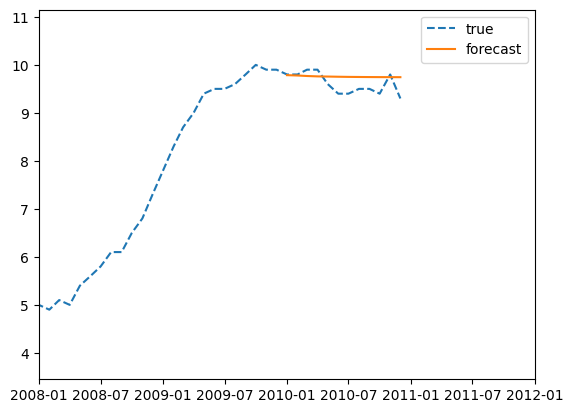

In [126]:
ran = np.arange('2010-01-01','2011-01-01',dtype='datetime64[M]')
plt.plot(df['unemp_rate'],label='true',ls="--")
plt.plot(ran,df_forecast['fore_unemp'],label='forecast')
plt.xlim(pd.to_datetime('2008'),pd.to_datetime('2012'))

plt.legend()

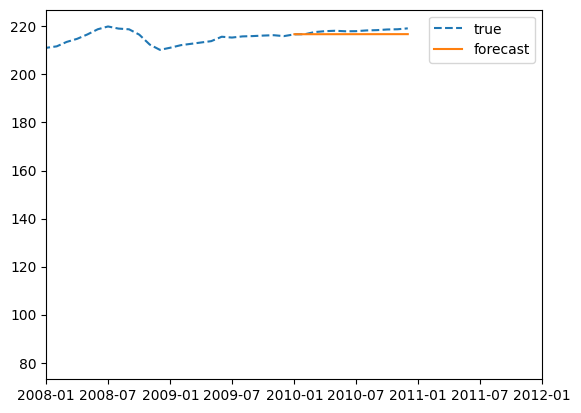

In [127]:
df_forecast['fore_infl'] = df['inflation_rate'].iloc[-test_obs-1] + df_forecast['infl'].cumsum()
plt.plot(df['inflation_rate'],label='true',ls="--")
plt.plot(ran,df_forecast['fore_infl'],label='forecast')
plt.xlim(pd.to_datetime('2008'),pd.to_datetime('2012'))
plt.legend()

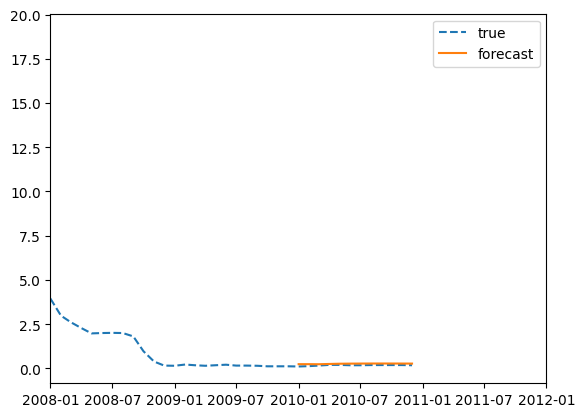

In [129]:
df_forecast['fore_inte'] = df['interest_rate'].iloc[-test_obs-1] + df_forecast['rate'].cumsum()
plt.plot(df['interest_rate'],label='true',ls="--")
plt.plot(ran,df_forecast['fore_inte'],label='forecast')
plt.xlim(pd.to_datetime('2008'),pd.to_datetime('2012'))

plt.legend()